In [57]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sys
import math
import numpy as np
import csv as csvD
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset_circles.zip to dataset_circles.zip


In [3]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_circles.zip']), 'r')
data.extractall()

In [4]:
dir_dataset_circles_directory = "/content/dataset_circles"

In [5]:
def detectCircles(image_name, directory):
  dir_image = f'{directory}/{image_name}'  
  # Read image as gray-scale
  img = cv2.imread(dir_image, cv2.IMREAD_COLOR)  
  # Convert to gray-scale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #plt.imshow(gray)
  #plt.show()
  # Blur the image to reduce noise
  img_blur = cv2.medianBlur(gray, 1)
  #plt.imshow(img_blur)
  #plt.show()   
  # Apply hough transform on the image
  circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=30)
  circlesToReturn = 0
  # Draw detected circles
  if circles is not None:
      #print(circles.size)
      circlesToReturn = circles.size
      circles = np.uint16(np.around(circles))
      for i in circles[0, :]:
          # Draw outer circle
          cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
          # Draw inner circle
          cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)
  else:
     print("No circles")
  
  return circlesToReturn

  #plt.imshow(img)
  #plt.show() 

In [60]:
def createCSV():
  header = ['circles', 'proximity', 'prediction']
  with open('/content/circlesdataset.csv', 'w', encoding='UTF8') as f:
    writer = csvD.writer(f)
    # write the header
    writer.writerow(header)

In [61]:
def addRowToCSV(data):
  with open('/content/circlesdataset.csv', 'w', encoding='UTF8') as f:
    writer = csvD.writer(f)
    # write the data
    writer.writerows(data)
  

In [62]:
createCSV()

In [63]:
circlesModel = detectCircles("circulo.png", "/content/")
toPrintModel = f'Model---{circlesModel}' 
print(toPrintModel)


Model---138


Build CSV

In [64]:
dir_circles_images = os.listdir(dir_dataset_circles_directory)
rows = []
rows.append(['circles', 'proximity', 'prediction'])
for image_name in dir_circles_images:
  if image_name.startswith("nosano"):
    circles_nosanos = detectCircles(image_name, dir_dataset_circles_directory)
    proximity = round(circles_nosanos / circlesModel, 2)
    toPrint = f'{image_name}---{circles_nosanos} -- {proximity}' 
    rows.append([circles_nosanos, proximity, 'nosano']) 
    

In [65]:
for image_name in dir_circles_images:
  if image_name.startswith("sano"):    
    circles_sanos = detectCircles(image_name, dir_dataset_circles_directory)
    proximity_sanos = round(circles_sanos / circlesModel, 2)
    toPrint = f'{image_name}---{circles_sanos} -- {proximity}' 
    rows.append([circles_sanos, proximity_sanos, 'sano'])   
     

In [66]:
addRowToCSV(rows) 

Analize CSV data

In [67]:
dataframe = pd.read_csv(r"circlesdataset.csv",sep=',')
dataframe.head(10)

,circles,proximity,prediction
0,42,0.30,nosano
1,327,2.37,nosano
2,48,0.35,nosano
3,45,0.33,nosano
4,48,0.35,nosano
5,69,0.50,nosano
6,69,0.50,nosano
7,387,2.80,nosano
8,81,0.59,nosano
9,63,0.46,nosano


In [68]:
dataframe.describe()

,circles,proximity
count,161.000000,161.000000
mean,73.714286,0.534286
std,54.916918,0.397910
min,15.000000,0.110000
25%,51.000000,0.370000
50%,63.000000,0.460000
75%,78.000000,0.570000
max,387.000000,2.800000


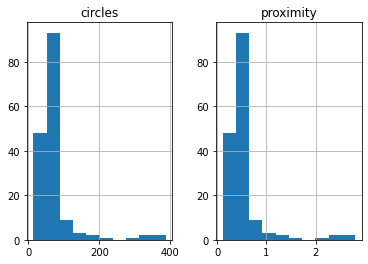

In [69]:
dataframe.hist()
plt.show()

In [70]:

X = dataframe[['circles','proximity']].values
y = dataframe['prediction'].values

In [73]:
X.size

322

In [75]:
y.size

161

KNN classifier

In [76]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

In [77]:
# split into test and train dataset, and use random_state=48
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
# build KNN model and choose n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors = 5)
# train the model
knn.fit(X_train, y_train)
# get the predict value from X_test
y_pred = knn.predict(X_test)
# print the score
print('accuracy: ', knn.score(X_test, y_test))

accuracy:  0.43902439024390244


              precision    recall  f1-score   support

      nosano       0.56      0.40      0.47        25
        sano       0.35      0.50      0.41        16

    accuracy                           0.44        41
   macro avg       0.45      0.45      0.44        41
weighted avg       0.47      0.44      0.44        41



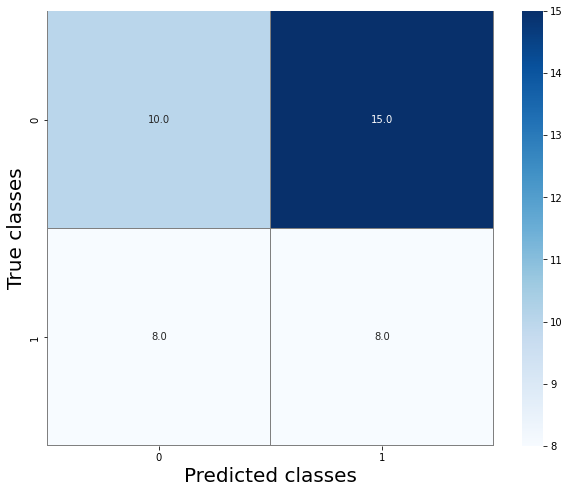

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

confusionMatrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(confusionMatrix, linewidths = 0.1, cmap = 'Blues', linecolor = 'gray', fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

print(classification_report(y_test, y_pred))
